In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import pandas_datareader
from datetime import date
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance

# In this notebook we will build a model around Apple's historical stock price using Long Short-Term Memory (LSTM)

In [101]:
window = 50

In [5]:
# Load in intitial datasets
ticker = 'spy'
vixtick = '^vix'
tenyrtick = '^tnx'
startdate = '2006-01-01'

spy = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
spy.reset_index(inplace=True)

vix = pandas_datareader.DataReader(vixtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
vix.reset_index(inplace=True)

tenyr = pandas_datareader.DataReader(tenyrtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
tenyr.reset_index(inplace=True)


<AxesSubplot:>

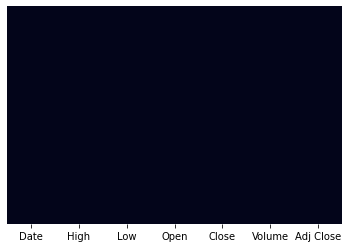

In [6]:
sns.heatmap(spy.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:>

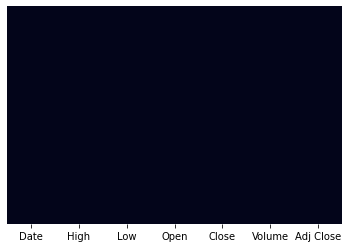

In [7]:
sns.heatmap(vix.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:>

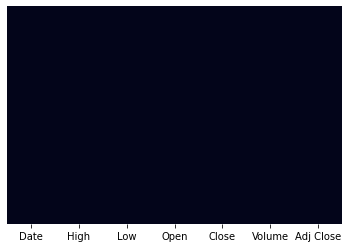

In [8]:
sns.heatmap(tenyr.isnull(), yticklabels=False, cbar=False)

## Data cleaning

In [9]:
spy.head()

Date        High         Low        Open       Close      Volume  \
0 2006-01-03  127.000000  124.389999  125.190002  126.699997  73256700.0   
1 2006-01-04  127.489998  126.699997  126.860001  127.300003  51899600.0   
2 2006-01-05  127.589996  126.879997  127.150002  127.379997  47307500.0   
3 2006-01-06  128.580002  127.360001  128.020004  128.440002  62885900.0   
4 2006-01-09  129.059998  128.380005  128.419998  128.770004  43527400.0   

   Adj Close  
0  91.405457  
1  91.838318  
2  91.896042  
3  92.660759  
4  92.898849

In [10]:
vix.head()

Date   High    Low   Open  Close  Volume  Adj Close
0 2006-01-03  12.51  10.99  12.25  11.14       0      11.14
1 2006-01-04  11.71  10.97  11.22  11.37       0      11.37
2 2006-01-05  11.84  11.31  11.43  11.31       0      11.31
3 2006-01-06  11.50  10.81  11.23  11.00       0      11.00
4 2006-01-09  11.35  10.98  11.35  11.13       0      11.13

In [11]:
tenyr.head()

Date   High    Low   Open  Close  Volume  Adj Close
0 2006-01-03  4.428  4.348  4.424  4.370     0.0      4.370
1 2006-01-04  4.399  4.342  4.362  4.356     0.0      4.356
2 2006-01-05  4.381  4.340  4.366  4.356     0.0      4.356
3 2006-01-06  4.413  4.328  4.362  4.379     0.0      4.379
4 2006-01-09  4.393  4.362  4.365  4.379     0.0      4.379

In [12]:
spy.tail()

Date        High         Low        Open       Close       Volume  \
4257 2022-11-30  407.679993  393.480011  395.489990  407.679993  144566700.0   
4258 2022-12-01  410.000000  404.750000  408.769989  407.380005   76398200.0   
4259 2022-12-02  407.859985  402.140015  402.250000  406.910004   85273900.0   
4260 2022-12-05  404.929993  398.170013  403.950012  399.589996   77289800.0   
4261 2022-12-06  399.984985  391.640015  399.420013  393.829987   76289886.0   

       Adj Close  
4257  407.679993  
4258  407.380005  
4259  406.910004  
4260  399.589996  
4261  393.829987

In [13]:
tenyr.tail()

Date   High    Low   Open  Close  Volume  Adj Close
4253 2022-11-30  3.798  3.690  3.727  3.703     0.0      3.703
4254 2022-12-01  3.631  3.527  3.594  3.529     0.0      3.529
4255 2022-12-02  3.638  3.504  3.519  3.506     0.0      3.506
4256 2022-12-05  3.612  3.513  3.530  3.599     0.0      3.599
4257 2022-12-06  3.583  3.508  3.561  3.513     0.0      3.513

In [14]:
# Convert date column to datetime from string so that it can easily be operated on
spy['Date'] = pd.to_datetime(spy['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
tenyr['Date'] = pd.to_datetime(tenyr['Date'])
spy.head()

Date        High         Low        Open       Close      Volume  \
0 2006-01-03  127.000000  124.389999  125.190002  126.699997  73256700.0   
1 2006-01-04  127.489998  126.699997  126.860001  127.300003  51899600.0   
2 2006-01-05  127.589996  126.879997  127.150002  127.379997  47307500.0   
3 2006-01-06  128.580002  127.360001  128.020004  128.440002  62885900.0   
4 2006-01-09  129.059998  128.380005  128.419998  128.770004  43527400.0   

   Adj Close  
0  91.405457  
1  91.838318  
2  91.896042  
3  92.660759  
4  92.898849

In [15]:
# Rename columns appropriately data 
spy.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
vix.rename(columns={'Adj Close': 'VIX_AdjClose'}, inplace=True)
tenyr.rename(columns={'Adj Close': 'TenYr_AdjClose'}, inplace=True)


In [16]:
# Clean spy data 
spy.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1, inplace=True)
spy

Date    AdjClose
0    2006-01-03   91.405457
1    2006-01-04   91.838318
2    2006-01-05   91.896042
3    2006-01-06   92.660759
4    2006-01-09   92.898849
...         ...         ...
4257 2022-11-30  407.679993
4258 2022-12-01  407.380005
4259 2022-12-02  406.910004
4260 2022-12-05  399.589996
4261 2022-12-06  393.829987

[4262 rows x 2 columns]

In [17]:
# Clean and relabel vix data 
vix.drop(['Volume', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1, inplace=True)
vix

Date  VIX_AdjClose
0    2006-01-03     11.140000
1    2006-01-04     11.370000
2    2006-01-05     11.310000
3    2006-01-06     11.000000
4    2006-01-09     11.130000
...         ...           ...
4257 2022-11-30     20.580000
4258 2022-12-01     19.840000
4259 2022-12-02     19.059999
4260 2022-12-05     20.750000
4261 2022-12-06     22.170000

[4262 rows x 2 columns]

In [18]:
# Clean and relabel bond data 
tenyr.drop(['High', 'Low', 'Volume', 'Open', 'Close'], axis=1, inplace=True)
tenyr

Date  TenYr_AdjClose
0    2006-01-03           4.370
1    2006-01-04           4.356
2    2006-01-05           4.356
3    2006-01-06           4.379
4    2006-01-09           4.379
...         ...             ...
4253 2022-11-30           3.703
4254 2022-12-01           3.529
4255 2022-12-02           3.506
4256 2022-12-05           3.599
4257 2022-12-06           3.513

[4258 rows x 2 columns]

In [19]:
vix

Date  VIX_AdjClose
0    2006-01-03     11.140000
1    2006-01-04     11.370000
2    2006-01-05     11.310000
3    2006-01-06     11.000000
4    2006-01-09     11.130000
...         ...           ...
4257 2022-11-30     20.580000
4258 2022-12-01     19.840000
4259 2022-12-02     19.059999
4260 2022-12-05     20.750000
4261 2022-12-06     22.170000

[4262 rows x 2 columns]

In [20]:
# Join dataframes together based on date 
spyvix = spy.merge(vix, how='inner', on=['Date'])
df = spyvix.merge(tenyr, how='inner', on=['Date'])
df

Date    AdjClose  VIX_AdjClose  TenYr_AdjClose
0    2006-01-03   91.405457     11.140000           4.370
1    2006-01-04   91.838318     11.370000           4.356
2    2006-01-05   91.896042     11.310000           4.356
3    2006-01-06   92.660759     11.000000           4.379
4    2006-01-09   92.898849     11.130000           4.379
...         ...         ...           ...             ...
4253 2022-11-30  407.679993     20.580000           3.703
4254 2022-12-01  407.380005     19.840000           3.529
4255 2022-12-02  406.910004     19.059999           3.506
4256 2022-12-05  399.589996     20.750000           3.599
4257 2022-12-06  393.829987     22.170000           3.513

[4258 rows x 4 columns]

<AxesSubplot:>

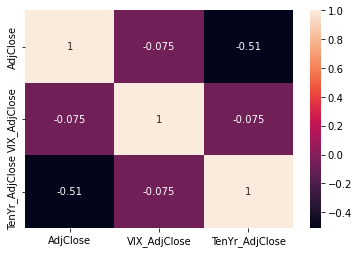

In [21]:
sns.heatmap(df.corr(), annot=True)

Text(0, 0.5, 'correlation')

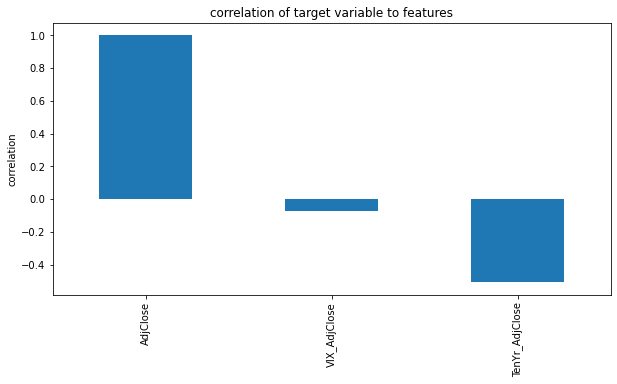

In [22]:
# Plot correlation of the NextDayChange to current features
plt.figure(figsize=(10,5))
ax = df.corr()['AdjClose'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

In [23]:
# Set index to date so that we can display a stock chart
df.set_index('Date', inplace=True)
df.head()

AdjClose  VIX_AdjClose  TenYr_AdjClose
Date                                               
2006-01-03  91.405457         11.14           4.370
2006-01-04  91.838318         11.37           4.356
2006-01-05  91.896042         11.31           4.356
2006-01-06  92.660759         11.00           4.379
2006-01-09  92.898849         11.13           4.379

## View the data we have based on mid price of the day

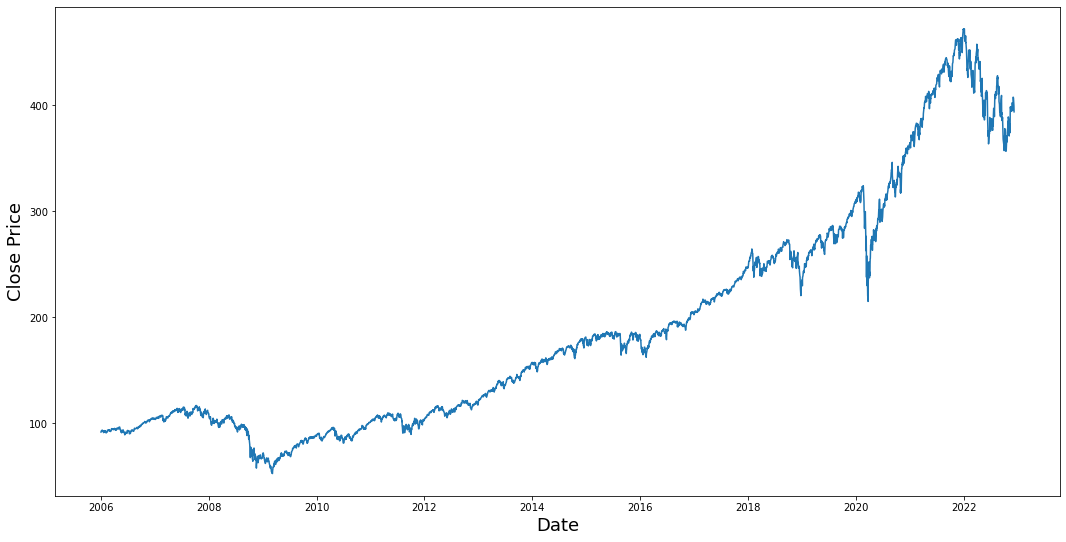

In [24]:
# Show adjusted close price of apple since 2007 (essentially a stock price chart) 
plt.figure(figsize = (18,9))
plt.plot(df['AdjClose'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

## Now let's normalize our data

In [25]:
df

AdjClose  VIX_AdjClose  TenYr_AdjClose
Date                                                
2006-01-03   91.405457     11.140000           4.370
2006-01-04   91.838318     11.370000           4.356
2006-01-05   91.896042     11.310000           4.356
2006-01-06   92.660759     11.000000           4.379
2006-01-09   92.898849     11.130000           4.379
...                ...           ...             ...
2022-11-30  407.679993     20.580000           3.703
2022-12-01  407.380005     19.840000           3.529
2022-12-02  406.910004     19.059999           3.506
2022-12-05  399.589996     20.750000           3.599
2022-12-06  393.829987     22.170000           3.513

[4258 rows x 3 columns]

In [26]:
# Normalize data 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) # We will normalize between 0 and 1
data_scaled = scaler.fit_transform(df) # Perform normalization
data_scaled

array([[0.09334617, 0.02719239, 0.81511892],
       [0.09437668, 0.0303195 , 0.81217095],
       [0.0945141 , 0.02950374, 0.81217095],
       ...,
       [0.84446415, 0.13487422, 0.63318592],
       [0.82703749, 0.15785179, 0.65276898],
       [0.8133247 , 0.17715839, 0.63465991]])

## Below we select train and test data and perform reshaping

In [27]:
# Train test split
X_train = []
y_train = []
X_test = []
y_test = []

# Select how much data we want to train / test on (75% for LSTM is appropriate)
# Important to note that train and test sets must be near each other since this is time-series data
training_size = round(len(data_scaled) * 0.75)
training_data = data_scaled[:training_size]
test_data = data_scaled[training_size:]

for i in range(window, len(training_data)):
    # Training will use the trailing window days (can tweak this parameter)
    X_train.append(data_scaled[i-window:i, :])
    # Test uses the day following the previous window days' adjusted close
    y_train.append(data_scaled[i, 0])

for i in range(len(training_data)+window, len(data_scaled)):
    # Testing will use the trailing window days (can tweak this parameter)
    X_test.append(data_scaled[i-window:i, :])
    y_test.append(data_scaled[i, 0])

X_test

[array([[0.5164875 , 0.06172671, 0.52684772],
        [0.5199643 , 0.0496261 , 0.53674458],
        [0.52065065, 0.03548606, 0.54411452],
        [0.52587693, 0.03616587, 0.54306169],
        [0.52528307, 0.03453433, 0.54095599],
        [0.52312514, 0.04160434, 0.54306169],
        [0.52252459, 0.04459551, 0.54811537],
        [0.52058926, 0.05098572, 0.539482  ],
        [0.52239112, 0.04445954, 0.53842912],
        [0.52245796, 0.04051665, 0.53842912],
        [0.52470475, 0.03888511, 0.5434828 ],
        [0.52432652, 0.03956492, 0.53842912],
        [0.52468238, 0.03358259, 0.56053905],
        [0.51961055, 0.06906866, 0.56811959],
        [0.51600661, 0.07722637, 0.57401554],
        [0.51600661, 0.08905505, 0.57570014],
        [0.51507229, 0.09259006, 0.57043585],
        [0.49482896, 0.18789937, 0.57401554],
        [0.48119242, 0.21536368, 0.55464304],
        [0.48960152, 0.16546565, 0.55632764],
        [0.48615341, 0.16532969, 0.56096021],
        [0.49950054, 0.11529572, 0

In [28]:
# Convert each dataset to numpy arrays again
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [29]:
X_train

array([[[0.09334617, 0.02719239, 0.81511892],
        [0.09437668, 0.0303195 , 0.81217095],
        [0.0945141 , 0.02950374, 0.81217095],
        ...,
        [0.09993631, 0.03154316, 0.88481787],
        [0.09855681, 0.0331747 , 0.90103174],
        [0.09995356, 0.0246091 , 0.90777002]],

       [[0.09437668, 0.0303195 , 0.81217095],
        [0.0945141 , 0.02950374, 0.81217095],
        [0.09633465, 0.02528891, 0.81701412],
        ...,
        [0.09855681, 0.0331747 , 0.90103174],
        [0.09995356, 0.0246091 , 0.90777002],
        [0.09955702, 0.03303874, 0.91724571]],

       [[0.0945141 , 0.02950374, 0.81217095],
        [0.09633465, 0.02528891, 0.81701412],
        [0.09690147, 0.02705642, 0.81701412],
        ...,
        [0.09995356, 0.0246091 , 0.90777002],
        [0.09955702, 0.03303874, 0.91724571],
        [0.09960868, 0.03059143, 0.9168246 ]],

       ...,

       [[0.4881858 , 0.04309993, 0.51105497],
        [0.48583854, 0.05723997, 0.50410609],
        [0.48687929, 0

In [30]:
X_test

array([[[0.5164875 , 0.06172671, 0.52684772],
        [0.5199643 , 0.0496261 , 0.53674458],
        [0.52065065, 0.03548606, 0.54411452],
        ...,
        [0.46206166, 0.19157034, 0.49505155],
        [0.46317383, 0.18354859, 0.49631499],
        [0.46330729, 0.17158395, 0.50115811]],

       [[0.5199643 , 0.0496261 , 0.53674458],
        [0.52065065, 0.03548606, 0.54411452],
        [0.52587693, 0.03616587, 0.54306169],
        ...,
        [0.46317383, 0.18354859, 0.49631499],
        [0.46330729, 0.17158395, 0.50115811],
        [0.46626582, 0.16750508, 0.50684351]],

       [[0.52065065, 0.03548606, 0.54411452],
        [0.52587693, 0.03616587, 0.54306169],
        [0.52528307, 0.03453433, 0.54095599],
        ...,
        [0.46330729, 0.17158395, 0.50115811],
        [0.46626582, 0.16750508, 0.50684351],
        [0.46606574, 0.15649217, 0.50789639]],

       ...,

       [[0.82501876, 0.19673691, 0.58812381],
        [0.83976605, 0.18558804, 0.59423037],
        [0.85012714, 0

In [31]:
y_train

array([0.09955702, 0.09960868, 0.09943624, ..., 0.51600036, 0.5197871 ,
       0.5198979 ])

In [32]:
y_test

array([0.46626582, 0.46606574, 0.45516552, ..., 0.84446415, 0.82703749,
       0.8133247 ])

In [33]:
X_train.shape

(3134, 60, 3)

In [34]:
# Reshape into 3D arrays 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

In [35]:
X_train.shape

(3134, 60, 3)

In [51]:
# Keras is a NN library built on top of Tensorflow that has LSTM built-in
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
print(X_train.shape)
print(y_train.shape)

(3134, 60, 3)
(3134,)


In [37]:
X_train.shape[1]

60

In [38]:
X_train.shape[2]

3

## Create LSTM model

In [39]:
# Create the LSTM model with dropout layer to prevent overfitting
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# Use a dropout of 20 to prevent overfitting (this will allow us to use our model for other stocks)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# Use a dropout of 20 to prevent overfitting (this will allow us to use our model for other stocks)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
# Use a dropout of 20 to prevent overfitting (this will allow us to use our model for other stocks)
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10800     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [2628]:
# Train the model on our training data
# Verbose just allows us to view the status of training as it happens
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
196/196 [==============================] - 5s 14ms/step - loss: 0.0017
Epoch 2/100
196/196 [==============================] - 3s 13ms/step - loss: 5.3642e-04
Epoch 3/100
196/196 [==============================] - 3s 13ms/step - loss: 3.7226e-04
Epoch 4/100
196/196 [==============================] - 3s 13ms/step - loss: 3.4657e-04
Epoch 5/100
196/196 [==============================] - 3s 13ms/step - loss: 2.6508e-04
Epoch 6/100
196/196 [==============================] - 3s 14ms/step - loss: 2.5937e-04
Epoch 7/100
196/196 [==============================] - 3s 13ms/step - loss: 2.2246e-04
Epoch 8/100
196/196 [==============================] - 3s 13ms/step - loss: 2.1090e-04
Epoch 9/100
196/196 [==============================] - 3s 13ms/step - loss: 1.8438e-04
Epoch 10/100
196/196 [==============================] - 3s 13ms/step - loss: 1.6390e-04
Epoch 11/100
196/196 [==============================] - 3s 14ms/step - loss: 1.7288e-04
Epoch 12/100
196/196 [=======================

In [2629]:
model.save('../models/LSTMmodelSPY_' + str(window))

INFO:tensorflow:Assets written to: ../models/LSTMmodelSPY_60\assets


INFO:tensorflow:Assets written to: ../models/LSTMmodelSPY_60\assets


In [52]:
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [2631]:
# Perform predictions
predicted_price = model.predict(X_test)

32/32 [==============================] - 1s 6ms/step


In [2632]:
predicted_price

array([[0.4704938 ],
       [0.46863768],
       [0.4686628 ],
       ...,
       [0.8433758 ],
       [0.85555077],
       [0.8613578 ]], dtype=float32)

In [2633]:
# Get something that can be inverse transformed
prediction_extended = np.zeros((len(predicted_price), 3))
prediction_extended[:, 0] = predicted_price[:, 0]
prediction_extended

array([[0.47049379, 0.        , 0.        ],
       [0.46863768, 0.        , 0.        ],
       [0.4686628 , 0.        , 0.        ],
       ...,
       [0.8433758 , 0.        , 0.        ],
       [0.85555077, 0.        , 0.        ],
       [0.86135781, 0.        , 0.        ]])

In [2634]:
y_test

array([0.46330731, 0.46626584, 0.46606564, ..., 0.84558308, 0.84446415,
       0.82703749])

In [2635]:
# Calculate root mean squared error for expected y values and the predictions from the model
math.sqrt(mean_squared_error(y_test, predicted_price))

0.020290671521745855

In [2636]:
# Transform predicted normalized values back to prices in dollars
predicted_price = scaler.inverse_transform(prediction_extended)
predicted_price

array([[249.82502564,   9.14000034,   0.49900001],
       [249.0453694 ,   9.14000034,   0.49900001],
       [249.05592238,   9.14000034,   0.49900001],
       ...,
       [406.45284709,   9.14000034,   0.49900001],
       [411.56689935,   9.14000034,   0.49900001],
       [414.00612768,   9.14000034,   0.49900001]])

In [2637]:
len(predicted_price)

1004

In [2638]:
len(spy)

4261

In [2639]:
# Create prediction df where the date is matched up with the predicted closing price for test data
prediction_df = pd.DataFrame(predicted_price[:, 0], columns=['Close'])
prediction_df

Close
0     249.825026
1     249.045369
2     249.055922
3     249.551412
4     247.478859
...          ...
999   404.268192
1000  401.999364
1001  406.452847
1002  411.566899
1003  414.006128

[1004 rows x 1 columns]

In [2640]:
spy[training_size+window:].reset_index()

index       Date    AdjClose
0      3253 2018-12-04  252.524963
1      3254 2018-12-06  252.141846
2      3255 2018-12-07  246.283066
3      3256 2018-12-10  246.750290
4      3257 2018-12-11  246.806366
...     ...        ...         ...
1003   4256 2022-11-29  395.230011
1004   4257 2022-11-30  407.679993
1005   4258 2022-12-01  407.380005
1006   4259 2022-12-02  406.910004
1007   4260 2022-12-05  399.589996

[1008 rows x 3 columns]

In [2641]:
df.reset_index(inplace=True)

In [2642]:
df

Date    AdjClose  VIX_AdjClose  TenYr_AdjClose
0    2006-01-03   91.405464     11.140000           4.370
1    2006-01-04   91.838310     11.370000           4.356
2    2006-01-05   91.896011     11.310000           4.356
3    2006-01-06   92.660713     11.000000           4.379
4    2006-01-09   92.898827     11.130000           4.379
...         ...         ...           ...             ...
4252 2022-11-29  395.230011     21.889999           3.748
4253 2022-11-30  407.679993     20.580000           3.703
4254 2022-12-01  407.380005     19.840000           3.529
4255 2022-12-02  406.910004     19.059999           3.506
4256 2022-12-05  399.589996     20.750000           3.599

[4257 rows x 4 columns]

In [2643]:
prediction_df['Date'] = df.iloc[training_size+window:]['Date'].values
prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])
prediction_df.head()

Close       Date
0  249.825026 2018-12-11
1  249.045369 2018-12-12
2  249.055922 2018-12-13
3  249.551412 2018-12-14
4  247.478859 2018-12-17

In [2644]:
# Create new dataframe with the Date as the index (so that dates appear on x-axis of plots)
df_dateind = df.copy()
df_dateind['Date'] = pd.to_datetime(df_dateind['Date'])
df_dateind = df_dateind.set_index('Date')
df_dateind

AdjClose  VIX_AdjClose  TenYr_AdjClose
Date                                                
2006-01-03   91.405464     11.140000           4.370
2006-01-04   91.838310     11.370000           4.356
2006-01-05   91.896011     11.310000           4.356
2006-01-06   92.660713     11.000000           4.379
2006-01-09   92.898827     11.130000           4.379
...                ...           ...             ...
2022-11-29  395.230011     21.889999           3.748
2022-11-30  407.679993     20.580000           3.703
2022-12-01  407.380005     19.840000           3.529
2022-12-02  406.910004     19.059999           3.506
2022-12-05  399.589996     20.750000           3.599

[4257 rows x 3 columns]

In [2645]:
# Set index of prediction dataframe to the Date so that it can be plotted with the entire dataset
prediction = prediction_df.set_index(['Date'])
prediction

Close
Date                  
2018-12-11  249.825026
2018-12-12  249.045369
2018-12-13  249.055922
2018-12-14  249.551412
2018-12-17  247.478859
...                ...
2022-11-29  404.268192
2022-11-30  401.999364
2022-12-01  406.452847
2022-12-02  411.566899
2022-12-05  414.006128

[1004 rows x 1 columns]

## Below we plot our prediction for the test data

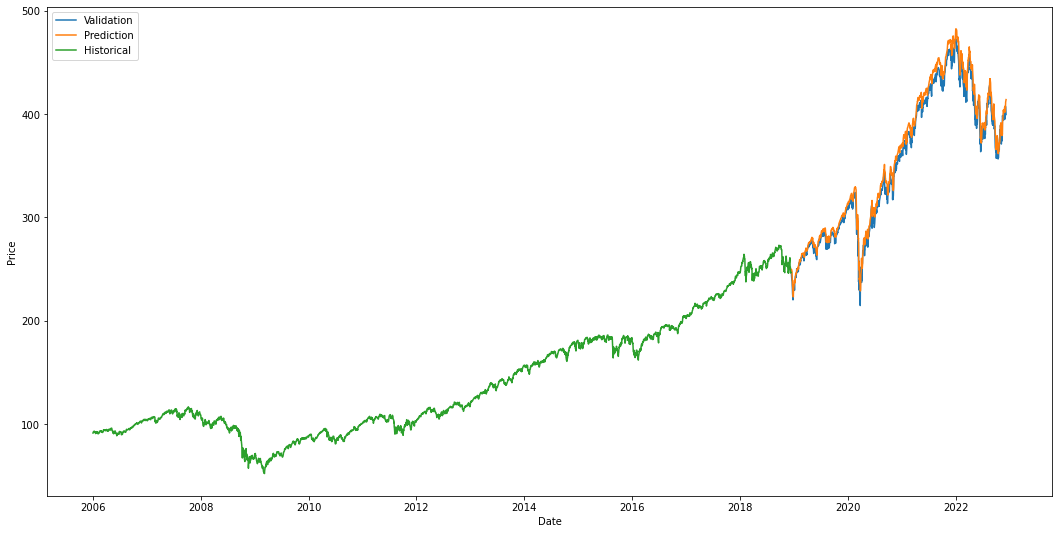

In [2646]:


# Create the plot for model's predictions on the test data 
plt.figure(figsize=(18,9))
# Plot the actual price of the test data
plt.plot(df_dateind[training_size+window:len(data_scaled)]['AdjClose'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction['Close'], label='Prediction')
plt.plot(df_dateind[:training_size+window]['AdjClose'], label='Historical')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

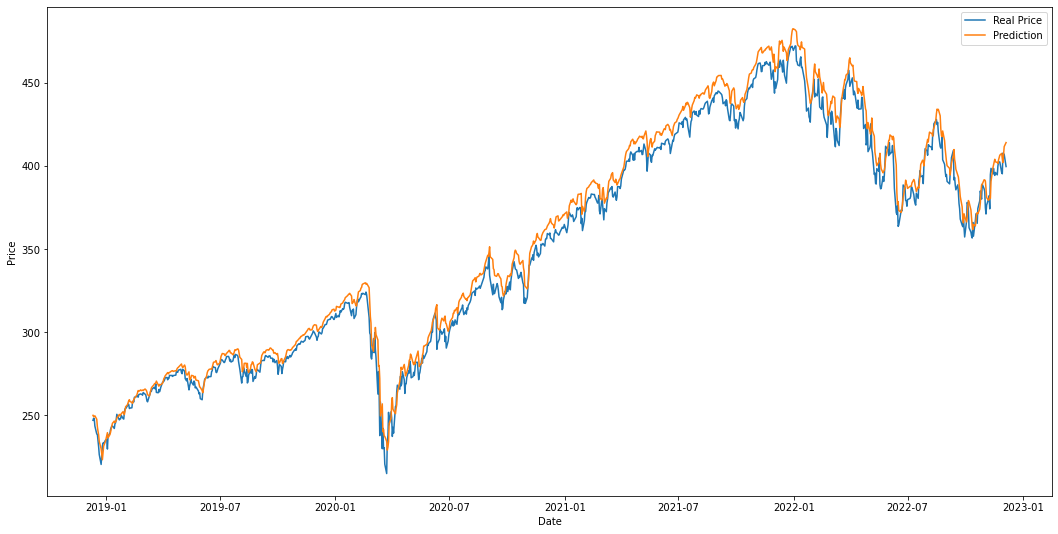

In [2647]:
# Create the plot for model's predictions on the test data 
plt.figure(figsize=(18,9))
# Plot the actual price of the test data
plt.plot(df_dateind[training_size+window:len(data_scaled)]['AdjClose'], label='Real Price')
# Plot the prediction on test data
plt.plot(prediction['Close'], label='Prediction')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

## Let's forecast

In [43]:
forecast_days = 5
window = 50

In [53]:
#model = tf.keras.models.load_model('../models/LSTMonelayer')
model = tf.keras.models.load_model('../models/LSTMmodelSPY_' + str(window))

In [54]:
window

50

In [55]:
import pandas_datareader
from datetime import date

In [56]:
# Load in intitial datasets
ticker = 'spy'
vixtick = '^vix'
tenyrtick = '^tnx'
startdate = startdate

spy = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
spy.reset_index(inplace=True)

vix = pandas_datareader.DataReader(vixtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
vix.reset_index(inplace=True)

tenyr = pandas_datareader.DataReader(tenyrtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
tenyr.reset_index(inplace=True)

### Clean data and create train/test sets like before

In [57]:
# Convert date column to datetime from string so that it can easily be operated on
spy['Date'] = pd.to_datetime(spy['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
tenyr['Date'] = pd.to_datetime(tenyr['Date'])

In [58]:
# Clean apple data 
spy.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
spy.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1, inplace=True)

In [59]:
# Clean and relabel vix data 
vix.rename(columns={'Adj Close': 'VIX_AdjClose'}, inplace=True)
vix.drop(['Volume', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1, inplace=True)

In [60]:
# Clean and relabel bond data 
tenyr.rename(columns={'Adj Close': 'TenYr_AdjClose'}, inplace=True)
tenyr.drop(['High', 'Low', 'Volume', 'Open', 'Close'], axis=1, inplace=True)

In [61]:
# Join dataframes together based on date 
spyvix = spy.merge(vix, how='inner', on=['Date'])
df = spyvix.merge(tenyr, how='inner', on=['Date'])

In [62]:
# Set index to date so that we can display a stock chart
df.set_index('Date', inplace=True)
df.head()

AdjClose  VIX_AdjClose  TenYr_AdjClose
Date                                               
2006-01-03  91.405464         11.14           4.370
2006-01-04  91.838303         11.37           4.356
2006-01-05  91.896027         11.31           4.356
2006-01-06  92.660774         11.00           4.379
2006-01-09  92.898827         11.13           4.379

In [63]:
# Normalize data 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) # We will normalize between 0 and 1
data_scaled = scaler.fit_transform(df) # Perform normalization
data_scaled

array([[0.09334616, 0.02719239, 0.81511892],
       [0.09437661, 0.0303195 , 0.81217095],
       [0.09451404, 0.02950374, 0.81217095],
       ...,
       [0.84446414, 0.13487422, 0.63318592],
       [0.82703748, 0.15785179, 0.65276898],
       [0.8133247 , 0.17715839, 0.63465991]])

In [64]:
data_scaled[-window:]

array([[0.74083278, 0.31896665, 0.72962726],
       [0.75785469, 0.28606389, 0.67508945],
       [0.73942818, 0.30863357, 0.68393343],
       [0.72607248, 0.30564242, 0.69593594],
       [0.74852236, 0.2849762 , 0.66371866],
       [0.77556701, 0.27097211, 0.65655928],
       [0.773472  , 0.26390208, 0.6864603 ],
       [0.76421116, 0.2906866 , 0.70056851],
       [0.73942818, 0.3021074 , 0.71257102],
       [0.73283363, 0.31692726, 0.7136239 ],
       [0.72740566, 0.33297077, 0.72436298],
       [0.72459647, 0.33215498, 0.71657188],
       [0.74699875, 0.3099932 , 0.7271004 ],
       [0.72714382, 0.31108089, 0.73931356],
       [0.74902235, 0.30224337, 0.74036634],
       [0.75928311, 0.29041467, 0.73678665],
       [0.75302189, 0.29394968, 0.76395025],
       [0.74566557, 0.28334464, 0.78479674],
       [0.7668061 , 0.27940176, 0.78205932],
       [0.77770962, 0.28157715, 0.78648138],
       [0.79211283, 0.26267843, 0.7599494 ],
       [0.78520877, 0.24663494, 0.74036634],
       [0.

In [65]:
vix_recentmean = data_scaled[-window:][:, 1].mean()
tenyr_recentmean = data_scaled[-window:][:, 2].mean()
vix_recentmean

0.2374819751993598

In [66]:
tenyr_recentmean

0.7134596534237885

In [67]:
# Train test split
X_train = []
y_train = []
X_test = []
y_test = []

# Select how much data we want to train / test on (75% for LSTM is appropriate)
# Important to note that train and test sets must be near each other since this is time-series data
training_size = round(len(data_scaled) * 0.75)
training_data = data_scaled[:training_size]
test_data = data_scaled[training_size:]

for i in range(window, len(training_data)):
    # Training will use the trailing window days (can tweak this parameter)
    X_train.append(data_scaled[i-window:i, :])
    # Test uses the day following the previous window days' adjusted close
    y_train.append(data_scaled[i, 0])

for i in range(len(training_data)+window, len(data_scaled)):
    # Testing will use the trailing window days (can tweak this parameter)
    X_test.append(data_scaled[i-window:i, :])
    y_test.append(data_scaled[i, 0])

X_test


[array([[0.51648734, 0.06172671, 0.52684772],
        [0.51996414, 0.0496261 , 0.53674458],
        [0.52065071, 0.03548606, 0.54411452],
        [0.52587692, 0.03616587, 0.54306169],
        [0.52528306, 0.03453433, 0.54095599],
        [0.52312512, 0.04160434, 0.54306169],
        [0.52252465, 0.04459551, 0.54811537],
        [0.52058932, 0.05098572, 0.539482  ],
        [0.52239111, 0.04445954, 0.53842912],
        [0.52245802, 0.04051665, 0.53842912],
        [0.52470474, 0.03888511, 0.5434828 ],
        [0.52432651, 0.03956492, 0.53842912],
        [0.52468244, 0.03358259, 0.56053905],
        [0.5196104 , 0.06906866, 0.56811959],
        [0.51600682, 0.07722637, 0.57401554],
        [0.51600682, 0.08905505, 0.57570014],
        [0.51507235, 0.09259006, 0.57043585],
        [0.49482917, 0.18789937, 0.57401554],
        [0.48119266, 0.21536368, 0.55464304],
        [0.48960136, 0.16546565, 0.55632764],
        [0.48615333, 0.16532969, 0.56096021],
        [0.49950074, 0.11529572, 0

In [68]:
# Convert each dataset to numpy arrays again
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [69]:
# Reshape into 3D arrays 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

In [70]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

In [71]:
len(X_test)

1014

In [72]:
df

AdjClose  VIX_AdjClose  TenYr_AdjClose
Date                                                
2006-01-03   91.405464     11.140000           4.370
2006-01-04   91.838303     11.370000           4.356
2006-01-05   91.896027     11.310000           4.356
2006-01-06   92.660774     11.000000           4.379
2006-01-09   92.898827     11.130000           4.379
...                ...           ...             ...
2022-11-30  407.679993     20.580000           3.703
2022-12-01  407.380005     19.840000           3.529
2022-12-02  406.910004     19.059999           3.506
2022-12-05  399.589996     20.750000           3.599
2022-12-06  393.829987     22.170000           3.513

[4258 rows x 3 columns]

32/32 [==============================] - 1s 6ms/step


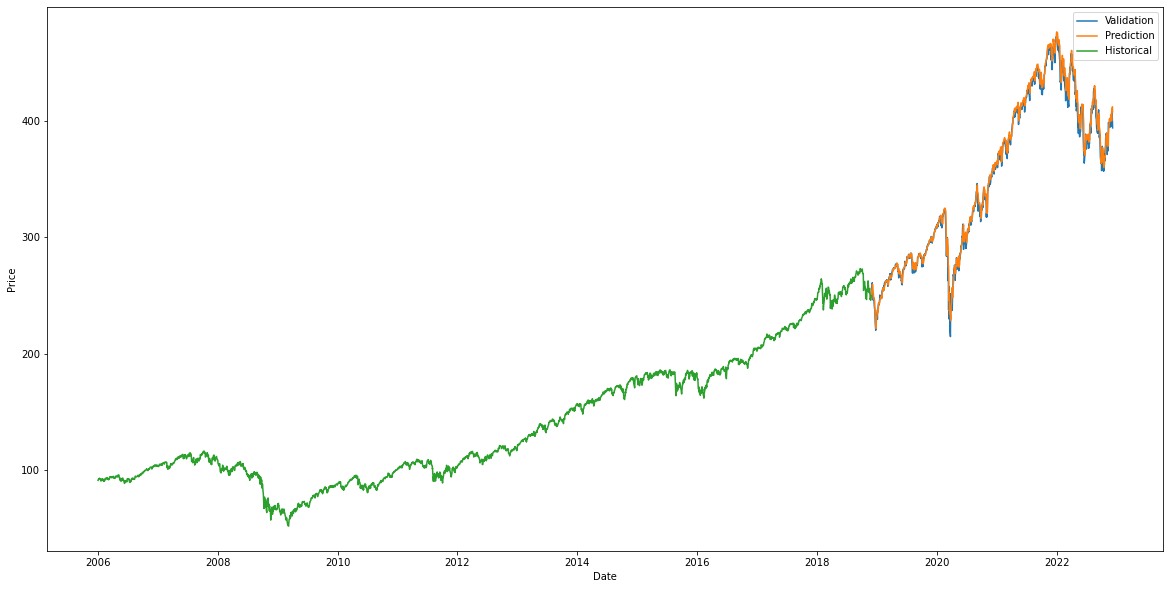

In [74]:
prediction = model.predict(X_test)
mse = math.sqrt(mean_squared_error(y_test, prediction))
prediction_extended = np.zeros((len(prediction), 3))
prediction_extended[:, 0] = prediction[:, 0]
predicted_price = scaler.inverse_transform(prediction_extended)

# Create prediction df where the date is matched up with the predicted closing price for test data
prediction_df = pd.DataFrame(predicted_price[:, 0], columns=['Close'])
df.reset_index(inplace=True)
prediction_df['Date'] = df.iloc[training_size+window:]['Date'].values
prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])

stock_dateind = df.copy()
stock_dateind['Date'] = pd.to_datetime(stock_dateind['Date'])
stock_dateind = stock_dateind.set_index('Date')

prediction_dateind = prediction_df.set_index(['Date'])

# Create the plot for model's predictions on the test data 
visualize = plt.figure(figsize=(20,10))
# Plot the actual price of the test data
plt.plot(stock_dateind[training_size+window-1:len(data_scaled)]['AdjClose'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction_dateind['Close'], label='Prediction')
# Plot the historicals 
plt.plot(stock_dateind[:training_size+window]['AdjClose'], label='Historical')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

## Use final window of data and turn it into data we can use to forecast

In [75]:
len(data_scaled)

4258

In [76]:
data_scaled

array([[0.09334616, 0.02719239, 0.81511892],
       [0.09437661, 0.0303195 , 0.81217095],
       [0.09451404, 0.02950374, 0.81217095],
       ...,
       [0.84446414, 0.13487422, 0.63318592],
       [0.82703748, 0.15785179, 0.65276898],
       [0.8133247 , 0.17715839, 0.63465991]])

In [77]:
X_test[-1]

array([[0.7430468 , 0.31434395, 0.7115182 ],
       [0.74083278, 0.31896665, 0.72962726],
       [0.75785469, 0.28606389, 0.67508945],
       [0.73942818, 0.30863357, 0.68393343],
       [0.72607248, 0.30564242, 0.69593594],
       [0.74852236, 0.2849762 , 0.66371866],
       [0.77556701, 0.27097211, 0.65655928],
       [0.773472  , 0.26390208, 0.6864603 ],
       [0.76421116, 0.2906866 , 0.70056851],
       [0.73942818, 0.3021074 , 0.71257102],
       [0.73283363, 0.31692726, 0.7136239 ],
       [0.72740566, 0.33297077, 0.72436298],
       [0.72459647, 0.33215498, 0.71657188],
       [0.74699875, 0.3099932 , 0.7271004 ],
       [0.72714382, 0.31108089, 0.73931356],
       [0.74902235, 0.30224337, 0.74036634],
       [0.75928311, 0.29041467, 0.73678665],
       [0.75302189, 0.29394968, 0.76395025],
       [0.74566557, 0.28334464, 0.78479674],
       [0.7668061 , 0.27940176, 0.78205932],
       [0.77770962, 0.28157715, 0.78648138],
       [0.79211283, 0.26267843, 0.7599494 ],
       [0.

In [78]:
data_scaled[-window:]

array([[0.74083278, 0.31896665, 0.72962726],
       [0.75785469, 0.28606389, 0.67508945],
       [0.73942818, 0.30863357, 0.68393343],
       [0.72607248, 0.30564242, 0.69593594],
       [0.74852236, 0.2849762 , 0.66371866],
       [0.77556701, 0.27097211, 0.65655928],
       [0.773472  , 0.26390208, 0.6864603 ],
       [0.76421116, 0.2906866 , 0.70056851],
       [0.73942818, 0.3021074 , 0.71257102],
       [0.73283363, 0.31692726, 0.7136239 ],
       [0.72740566, 0.33297077, 0.72436298],
       [0.72459647, 0.33215498, 0.71657188],
       [0.74699875, 0.3099932 , 0.7271004 ],
       [0.72714382, 0.31108089, 0.73931356],
       [0.74902235, 0.30224337, 0.74036634],
       [0.75928311, 0.29041467, 0.73678665],
       [0.75302189, 0.29394968, 0.76395025],
       [0.74566557, 0.28334464, 0.78479674],
       [0.7668061 , 0.27940176, 0.78205932],
       [0.77770962, 0.28157715, 0.78648138],
       [0.79211283, 0.26267843, 0.7599494 ],
       [0.78520877, 0.24663494, 0.74036634],
       [0.

### Reshape data so we can test on it 

In [79]:
start_forecast = X_test[-1]
start_forecast.shape

(50, 3)

In [80]:
start_forecast

array([[0.7430468 , 0.31434395, 0.7115182 ],
       [0.74083278, 0.31896665, 0.72962726],
       [0.75785469, 0.28606389, 0.67508945],
       [0.73942818, 0.30863357, 0.68393343],
       [0.72607248, 0.30564242, 0.69593594],
       [0.74852236, 0.2849762 , 0.66371866],
       [0.77556701, 0.27097211, 0.65655928],
       [0.773472  , 0.26390208, 0.6864603 ],
       [0.76421116, 0.2906866 , 0.70056851],
       [0.73942818, 0.3021074 , 0.71257102],
       [0.73283363, 0.31692726, 0.7136239 ],
       [0.72740566, 0.33297077, 0.72436298],
       [0.72459647, 0.33215498, 0.71657188],
       [0.74699875, 0.3099932 , 0.7271004 ],
       [0.72714382, 0.31108089, 0.73931356],
       [0.74902235, 0.30224337, 0.74036634],
       [0.75928311, 0.29041467, 0.73678665],
       [0.75302189, 0.29394968, 0.76395025],
       [0.74566557, 0.28334464, 0.78479674],
       [0.7668061 , 0.27940176, 0.78205932],
       [0.77770962, 0.28157715, 0.78648138],
       [0.79211283, 0.26267843, 0.7599494 ],
       [0.

In [81]:
start_forecast = np.reshape(start_forecast, (start_forecast.shape[0], start_forecast.shape[1], 1))
start_forecast.shape

(50, 3, 1)

In [82]:
# Reshape so that data looks like X_test input from earlier cells 
start_forecast = start_forecast.reshape(1, window, 3)
start_forecast.shape

(1, 50, 3)

In [83]:
start_forecast

array([[[0.7430468 , 0.31434395, 0.7115182 ],
        [0.74083278, 0.31896665, 0.72962726],
        [0.75785469, 0.28606389, 0.67508945],
        [0.73942818, 0.30863357, 0.68393343],
        [0.72607248, 0.30564242, 0.69593594],
        [0.74852236, 0.2849762 , 0.66371866],
        [0.77556701, 0.27097211, 0.65655928],
        [0.773472  , 0.26390208, 0.6864603 ],
        [0.76421116, 0.2906866 , 0.70056851],
        [0.73942818, 0.3021074 , 0.71257102],
        [0.73283363, 0.31692726, 0.7136239 ],
        [0.72740566, 0.33297077, 0.72436298],
        [0.72459647, 0.33215498, 0.71657188],
        [0.74699875, 0.3099932 , 0.7271004 ],
        [0.72714382, 0.31108089, 0.73931356],
        [0.74902235, 0.30224337, 0.74036634],
        [0.75928311, 0.29041467, 0.73678665],
        [0.75302189, 0.29394968, 0.76395025],
        [0.74566557, 0.28334464, 0.78479674],
        [0.7668061 , 0.27940176, 0.78205932],
        [0.77770962, 0.28157715, 0.78648138],
        [0.79211283, 0.26267843, 0

In [84]:
forecast_days

5

In [85]:
forecast_list = start_forecast

In [86]:
forecast_list.shape

(1, 50, 3)

In [87]:
forecast_list.reshape(1, window, 3)
forecast_list.shape

(1, 50, 3)

In [88]:
forecast_list

array([[[0.7430468 , 0.31434395, 0.7115182 ],
        [0.74083278, 0.31896665, 0.72962726],
        [0.75785469, 0.28606389, 0.67508945],
        [0.73942818, 0.30863357, 0.68393343],
        [0.72607248, 0.30564242, 0.69593594],
        [0.74852236, 0.2849762 , 0.66371866],
        [0.77556701, 0.27097211, 0.65655928],
        [0.773472  , 0.26390208, 0.6864603 ],
        [0.76421116, 0.2906866 , 0.70056851],
        [0.73942818, 0.3021074 , 0.71257102],
        [0.73283363, 0.31692726, 0.7136239 ],
        [0.72740566, 0.33297077, 0.72436298],
        [0.72459647, 0.33215498, 0.71657188],
        [0.74699875, 0.3099932 , 0.7271004 ],
        [0.72714382, 0.31108089, 0.73931356],
        [0.74902235, 0.30224337, 0.74036634],
        [0.75928311, 0.29041467, 0.73678665],
        [0.75302189, 0.29394968, 0.76395025],
        [0.74566557, 0.28334464, 0.78479674],
        [0.7668061 , 0.27940176, 0.78205932],
        [0.77770962, 0.28157715, 0.78648138],
        [0.79211283, 0.26267843, 0

In [89]:
for i in range(forecast_days):
    x = forecast_list[-window:] # Get the most recent "window" days (need this many for a prediction)
    out = model.predict(x) # Get the value of the next day that is predicted
    out = np.append(out, vix_recentmean)
    out = np.append(out, tenyr_recentmean)
    forecast_list = np.append(forecast_list[0], out)
    forecast_list = forecast_list.reshape(1, window+i+1, 3)

1/1 [==============================] - 0s 25ms/step


In [90]:
forecast_list = scaler.inverse_transform(forecast_list.copy().reshape(-1, 3))
forecast_list

array([[364.30999756,  32.25999832,   3.87800002],
       [363.38000488,  32.59999847,   3.96399999],
       [370.52999878,  30.18000031,   3.70499992],
       [362.79000854,  31.84000015,   3.74699998],
       [357.17999268,  31.62000084,   3.8039999 ],
       [366.60998535,  30.10000038,   3.65100002],
       [377.97000122,  29.06999969,   3.6170001 ],
       [377.08999634,  28.54999924,   3.75900006],
       [373.20001221,  30.52000046,   3.82599998],
       [362.79000854,  31.36000061,   3.8829999 ],
       [360.01998901,  32.45000076,   3.88800001],
       [357.73999023,  33.63000107,   3.93899989],
       [356.55999756,  33.56999969,   3.90199995],
       [365.97000122,  31.94000053,   3.9519999 ],
       [357.63000488,  32.02000046,   4.01000023],
       [366.82000732,  31.37000084,   4.01499987],
       [371.13000488,  30.5       ,   3.99799991],
       [368.5       ,  30.76000023,   4.12699986],
       [365.41000366,  29.97999954,   4.22599983],
       [374.29000854,  29.69000

In [91]:
len(forecast_list)

55

In [92]:
def forecast_dates(df):
    final = df['Date'].values[-1]
    forecast_dates = pd.date_range(final, periods=forecast_days).tolist()
    return forecast_dates

In [93]:
forecast_df = pd.DataFrame(forecast_list[window:][: , 0], columns=['Close'])
forecast_df['Date'] = forecast_dates(df.reset_index())
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df.set_index('Date', inplace=True)

In [94]:
prediction_dateind.tail()


Close
Date                  
2022-11-30  399.897509
2022-12-01  404.120805
2022-12-02  409.310342
2022-12-05  411.885695
2022-12-06  407.603163

In [95]:
forecast_df

Close
Date                  
2022-12-06  407.603188
2022-12-07  400.886986
2022-12-08  400.204610
2022-12-09  400.990037
2022-12-10  402.275448

## Let's plot our forecast

In [96]:
len(forecast_df)

5

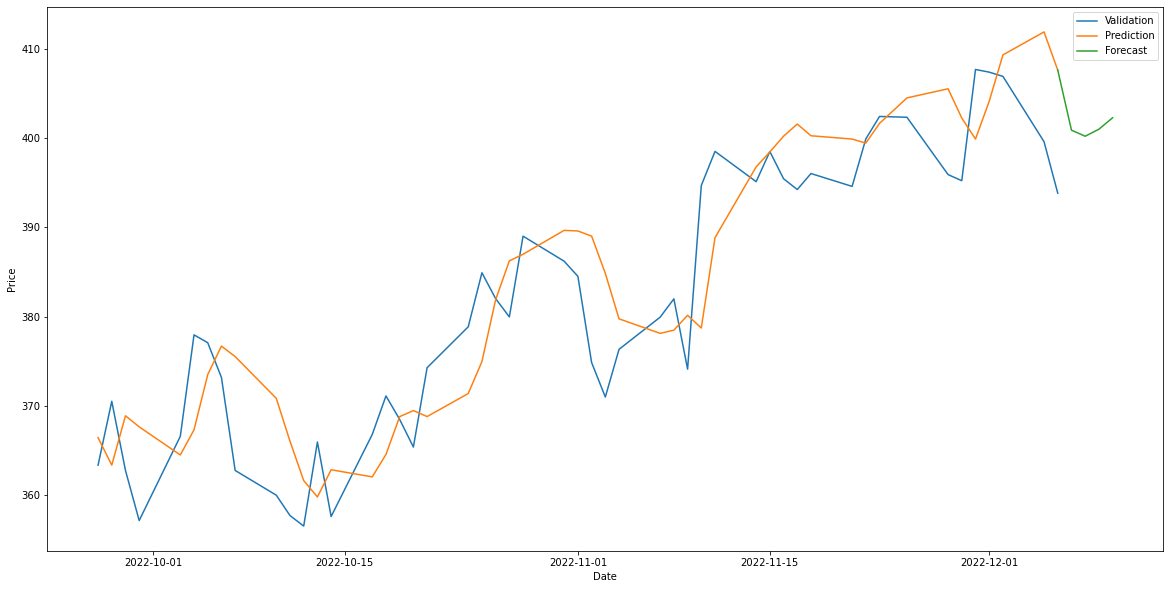

In [97]:
# Create the plot for model's predictions on the test data 
visualize = plt.figure(figsize=(20,10))
# Plot the actual price of the test data
plt.plot(stock_dateind[-50:]['AdjClose'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction_dateind[-50:]['Close'], label='Prediction')
# Plot the historicals 
plt.plot(forecast_df['Close'], label='Forecast')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

## Feature Analysis

In [102]:
#model = tf.keras.models.load_model('../models/LSTMonelayer')
model = tf.keras.models.load_model('../models/LSTMmodelSPY_' + str(window))


In [104]:
model.fit(X_test, y_test)


32/32 [==============================] - 2s 14ms/step - loss: 0.0017


In [108]:
perm = PermutationImportance(scoring='accuracy',model, random_state=1).fit(X_test, y_test)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x0000016B263AF490> does not.